In [1]:
import comet_ml
import torch
from datasets import load_from_disk

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_from_disk, Dataset
import random

# Load the dataset
tokenized_dataset = load_from_disk('/mnt/tony/MSc2024/data/tokenized_preprocessed_wikitext103.hf') #20231101
train_dataset = tokenized_dataset["train"]
val_dataset = tokenized_dataset["validation"]

def truncate_batch(batch, max_length=8):
    batch['input_ids'] = [ids[:max_length] for ids in batch['input_ids']]
    batch['attention_mask'] = [mask[:max_length] for mask in batch['attention_mask']]
    return batch

train_dataset = train_dataset.map(truncate_batch, batched=True)
val_dataset = val_dataset.map(truncate_batch, batched=True)

num_train_samples = 100  
num_val_samples = 20
train_subset = train_dataset.select(range(num_train_samples))
val_subset = val_dataset.select(range(num_val_samples))

print(f"Train Subset Size: {len(train_subset)}")
print(f"Validation Subset Size: {len(val_subset)}")


In [3]:
#comet_ml.init(project_name="distilbert_dotprod")
from transformers import AutoTokenizer
import random

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 85965
})


In [4]:
import torch
import torch.nn.functional as F
from transformers import Trainer, TrainingArguments, TrainerCallback
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup

class distillTrainer(Trainer):
    def __init__(self, *args, teacher_model = None, temperature = None, alpha_ce = None, **kwargs):
        super().__init__(*args,**kwargs)
        self.teacher = teacher_model
        self.teacher.eval()
        self.layer_groups = [f"transformer.layer.{i}" for i in range(6)] 
        self.current_layer_group = 0
        self.unfrozen_layers = set()
        self.layer_logs = []
        self.context_loss_stats = []
        
    def compute_loss(self, model, inputs, return_outputs = False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher(**inputs)
            teacher_logits = teacher_outputs.logits

        #student_contexts = torch.stack(student_outputs.contexts[:self.current_layer_group + 1])
        #teacher_contexts = torch.stack(teacher_outputs.contexts[:self.current_layer_group + 1])
        student_contexts = student_outputs.contexts[self.current_layer_group]
        teacher_contexts = teacher_outputs.contexts[self.current_layer_group]
        #l_ce = self.distillation_loss(student_logits, teacher_logits)  
    
        context_loss = F.mse_loss(student_contexts, teacher_contexts)

        student_stats = {
            'mean': student_contexts.mean().item(),
            'max': student_contexts.max().item(),
            'min': student_contexts.min().item()
        }
        teacher_stats = {
            'mean': teacher_contexts.mean().item(),
            'max': teacher_contexts.max().item(),
            'min': teacher_contexts.min().item()
        }

        self.context_loss_stats.append({
            'layer': self.current_layer_group,
            'student': student_stats,
            'teacher': teacher_stats,
        })
        
        return (context_loss, student_outputs) if return_outputs else context_loss
        
    def train(self, resume_from_checkpoint=None, **kwargs):
        layer_plots = []
        for layer_group in self.layer_groups:
            print(f"Training layer group: {layer_group}")
            self.switch_to_next_layer_group()
            print(self.get_num_trainable_parameters())
            res = super().train(resume_from_checkpoint=resume_from_checkpoint, **kwargs)
            self.layer_logs.append(self.state.log_history.copy())
            self.current_layer_group += 1
            #self.save_model(f"./results/layer_{layer_group}")
        self.plot_layer_losses()
        return res

    def freeze_all_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False
    
    def switch_to_next_layer_group(self):
        self.freeze_all_layers()
        print("Current layer", self.current_layer_group)
        
        if self.current_layer_group < len(self.layer_groups):
            current_layer = self.layer_groups[self.current_layer_group]
            newly_unfrozen_params = []
            
            for name, param in self.model.named_parameters():
                if current_layer in name and any(qkv in name for qkv in ['sa_layer_norm']): #v_lin q_lin k_lin
                    if name not in self.unfrozen_layers:
                        param.requires_grad = True
                        newly_unfrozen_params.append(param)
                        
            print(f"Unfrozen parameters for layer {self.current_layer_group}:")
            for name, param in self.model.named_parameters():
                if param.requires_grad:
                    print(f"  - {name}")

            optimizer_grouped_parameters = [
            {
                "params": newly_unfrozen_params,
                "weight_decay": self.args.weight_decay,
            }
            ]
            
            self.optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate)
            
            num_training_steps = len(self.train_dataset) // self.args.train_batch_size * self.args.num_train_epochs
            warmup_rate = 0.1  # 10% 
            warmup_steps = int(num_training_steps * warmup_rate)
            self.lr_scheduler = get_cosine_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=warmup_steps, 
                num_training_steps=num_training_steps
            )

    def plot_layer_losses(self):
        fig, axs = plt.subplots(2, 3, figsize=(20, 15))
        for layer, (ax, layer_logs) in enumerate(zip(axs.flatten(), self.layer_logs)):
            train_data = [(log['step'], log['loss']) for log in layer_logs if 'loss' in log]
            eval_data = [(log['step'], log['eval_loss']) for log in layer_logs if 'eval_loss' in log]
            
            if train_data:
                steps, losses = zip(*train_data)
                ax.plot(steps, losses, label='Train Loss')
            if eval_data:
                steps, losses = zip(*eval_data)
                ax.plot(steps, losses, label='Validation Loss')
            
            ax.set_title(f'Layer {layer} Loss')
            ax.set_xlabel('Steps')
            ax.set_ylabel('Loss')
            ax.legend()
        
        plt.tight_layout()
        plt.savefig('sa_layernorm.png')
        plt.close()
        




    

2024-09-19 13:11:24.283517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 13:11:24.307890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 13:11:24.307913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 13:11:24.330230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
#labels = tokenized_datasets['train'].features['label'].names
#num_labels = len(labels)
#label2id, id2label = {}, {}

#for idx, lbl in enumerate(labels):
#    label2id[lbl] = idx
#    id2label[idx] = lbl
#print(label2id)
#print(id2label)

In [6]:
from transformers import DistilBertConfig, DistilBertForMaskedLM
import torch.nn as nn

small_config = DistilBertConfig(
    n_layers=1,                
    dim=1,                   
    n_heads=1,                 
    attention_dropout=0.1,
    distance_metric="cosine_distance",
    activation_function="softmax",
    signed_inhibitor=False,
    alpha=0.0,
    center=False,
    output_contexts=True,
)

# Instantiate the teacher model with the small configuration
teacher_model = iDistilBertForMaskedLM.from_pretrained(
    "distilbert/distilbert-base-uncased",
    config=small_config,
)

# Define a different configuration for the student model
student_config = DistilBertConfig(
    n_layers=1,
    dim=1,
    n_heads=1,
    attention_dropout=0.1,
    distance_metric="manhattan_distance",
    activation_function="relu",
    signed_inhibitor=True,
    alpha=0.0,
    center=True,
    output_contexts=True,
)

student_model = iDistilBertForMaskedLM(student_config)

# initialized_weights = torch.load('/path/to/init_weights.pth')
# student_model.load_state_dict(initialized_weights, strict=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
teacher_model.to(device)
student_model.to(device)


iDistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): iDistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): iTransformer(
      (layer): ModuleList(
        (0-5): 6 x iTransformerBlock(
          (attention): iMultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout

In [7]:
EPOCHS = 1
BATCH_SIZE = 4
LEARNING_RATE = 5e-4
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = EPOCHS,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    learning_rate = LEARNING_RATE,
    logging_dir = './logs',
    load_best_model_at_end= True,
    metric_for_best_model="loss",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps = 134, 
    logging_steps = 100,
    save_steps=134,
    save_total_limit=2,
    seed = 42,
    #report_to=['comet_ml', 'tensorboard'],
    report_to=['tensorboard'],
    warmup_ratio=0.05,
    gradient_accumulation_steps=4,
    lr_scheduler_type="cosine",
)

trainer = distillTrainer(
    teacher_model=teacher_model,
    model=student_model,                         
    args=training_args,                  
    train_dataset=train_subset,         
    eval_dataset=val_dataset,
    tokenizer = tokenizer,
    data_collator = data_collator,
)


In [8]:
trainer.train()

Training layer group: transformer.layer.0
Current layer 0
Unfrozen parameters for layer 0:
  - distilbert.transformer.layer.0.sa_layer_norm.weight
  - distilbert.transformer.layer.0.sa_layer_norm.bias
1536


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
134,1.128100,1.125783
268,1.111500,1.076816
402,1.025900,1.003825
536,0.968300,0.914770
670,0.904900,0.829828
804,0.791000,0.756859
938,0.742400,0.693611
1072,0.697200,0.637619
1206,0.623000,0.588621
1340,0.591900,0.545143


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

Training layer group: transformer.layer.1
Current layer 1
Unfrozen parameters for layer 1:
  - distilbert.transformer.layer.1.sa_layer_norm.weight
  - distilbert.transformer.layer.1.sa_layer_norm.bias
1536


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
134,0.499100,0.479578
268,0.487600,0.448053
402,0.435300,0.402907
536,0.399000,0.354078
670,0.367500,0.313847
804,0.314100,0.284411
938,0.299400,0.263147
1072,0.281900,0.248562
1206,0.263600,0.237139
1340,0.257900,0.229037


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

Training layer group: transformer.layer.2
Current layer 2
Unfrozen parameters for layer 2:
  - distilbert.transformer.layer.2.sa_layer_norm.weight
  - distilbert.transformer.layer.2.sa_layer_norm.bias
1536


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
134,0.451300,0.384777
268,0.442300,0.358499
402,0.398600,0.324732
536,0.370700,0.290578
670,0.344900,0.265519
804,0.307600,0.250153
938,0.297800,0.240065
1072,0.287300,0.234125
1206,0.279100,0.230669
1340,0.274600,0.227879


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

Training layer group: transformer.layer.3
Current layer 3
Unfrozen parameters for layer 3:
  - distilbert.transformer.layer.3.sa_layer_norm.weight
  - distilbert.transformer.layer.3.sa_layer_norm.bias
1536


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
134,0.896500,0.880644
268,0.882800,0.845246
402,0.826000,0.791371
536,0.781900,0.734992
670,0.737800,0.681875
804,0.662300,0.640704
938,0.636800,0.605380
1072,0.606600,0.574882
1206,0.561700,0.549938
1340,0.545900,0.528006


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

Training layer group: transformer.layer.4
Current layer 4
Unfrozen parameters for layer 4:
  - distilbert.transformer.layer.4.sa_layer_norm.weight
  - distilbert.transformer.layer.4.sa_layer_norm.bias
1536


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
134,0.624900,0.611603
268,0.610900,0.580167
402,0.556400,0.533075
536,0.520900,0.482560
670,0.481900,0.438069
804,0.420400,0.403719
938,0.398500,0.375459
1072,0.378200,0.355001
1206,0.347300,0.337386
1340,0.335500,0.322995


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

Training layer group: transformer.layer.5
Current layer 5
Unfrozen parameters for layer 5:
  - distilbert.transformer.layer.5.sa_layer_norm.weight
  - distilbert.transformer.layer.5.sa_layer_norm.bias
1536


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
134,0.652700,0.575702
268,0.635800,0.545682
402,0.588100,0.507656
536,0.549400,0.465155
670,0.522100,0.430650
804,0.474100,0.404166
938,0.456000,0.384000
1072,0.440500,0.367983
1206,0.409700,0.358137
1340,0.401600,0.347814


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=1343, training_loss=0.5080961027166689, metrics={'train_runtime': 5537.3659, 'train_samples_per_second': 15.525, 'train_steps_per_second': 0.243, 'total_flos': 1.1393896488763392e+16, 'train_loss': 0.5080961027166689, 'epoch': 0.9998138842359948})

In [9]:
import os

folder = 'models/'
os.makedirs(folder, exist_ok=True)
torch.save(student_model.state_dict(), os.path.join(folder, 'layernorm_inhibit.pth'))

In [ ]:
try:
    output = student_model(input_ids=input_ids, attention_mask=attention_mask)
    print("Forward pass successful")
except Exception as e:
    print(f"Error during forward pass: {e}")

print(output.contexts[0].shape)


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_data(data, window_size):
    """Apply moving average smoothing to the data."""
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

def organize_data_by_layer(data):
    organized_data = {}
    for entry in data:
        layer = entry['layer']
        if layer not in organized_data:
            organized_data[layer] = {'student': {'mean': [], 'max': [], 'min': []},
                                     'teacher': {'mean': [], 'max': [], 'min': []}}
        for model in ['student', 'teacher']:
            for stat in ['mean', 'max', 'min']:
                organized_data[layer][model][stat].append(entry[model][stat])
    return organized_data

def plot_all_layers(data, smooth_window=100):
    organized_data = organize_data_by_layer(data)
    num_layers = len(organized_data)
    
    fig, axs = plt.subplots(num_layers, 3, figsize=(20, 8 * num_layers))
    fig.suptitle('Layer Statistics Comparison (Smoothed)', fontsize=16)
    
    if num_layers == 1:
        axs = axs.reshape(1, -1)
    
    colors = {'student': 'blue', 'teacher': 'red'}
    stats = ['mean', 'max', 'min']
    
    for layer, (layer_num, layer_data) in enumerate(sorted(organized_data.items())):
        for col, stat in enumerate(stats):
            ax = axs[layer, col]
            for model in ['student', 'teacher']:
                original_data = layer_data[model][stat]
                
                # Plot original data with low alpha
                ax.plot(original_data, color=colors[model], alpha=0.3, linewidth=1)
                
                # Smooth and plot the data
                if len(original_data) > smooth_window:
                    smoothed_data = smooth_data(original_data, smooth_window)
                    ax.plot(range(smooth_window-1, len(original_data)), smoothed_data, 
                            color=colors[model], label=f'{model.capitalize()} (Smoothed)')
                else:
                    ax.plot(original_data, color=colors[model], label=model.capitalize())
            
            ax.set_title(f'Layer {layer_num} - {stat.capitalize()}', fontsize=12)
            ax.set_xlabel('Steps', fontsize=10)
            ax.set_ylabel('Value', fontsize=10)
            ax.legend(fontsize=8)
            ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('all_layers_stats_smoothed2.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

In [11]:
plot_all_layers(trainer.context_loss_stats)

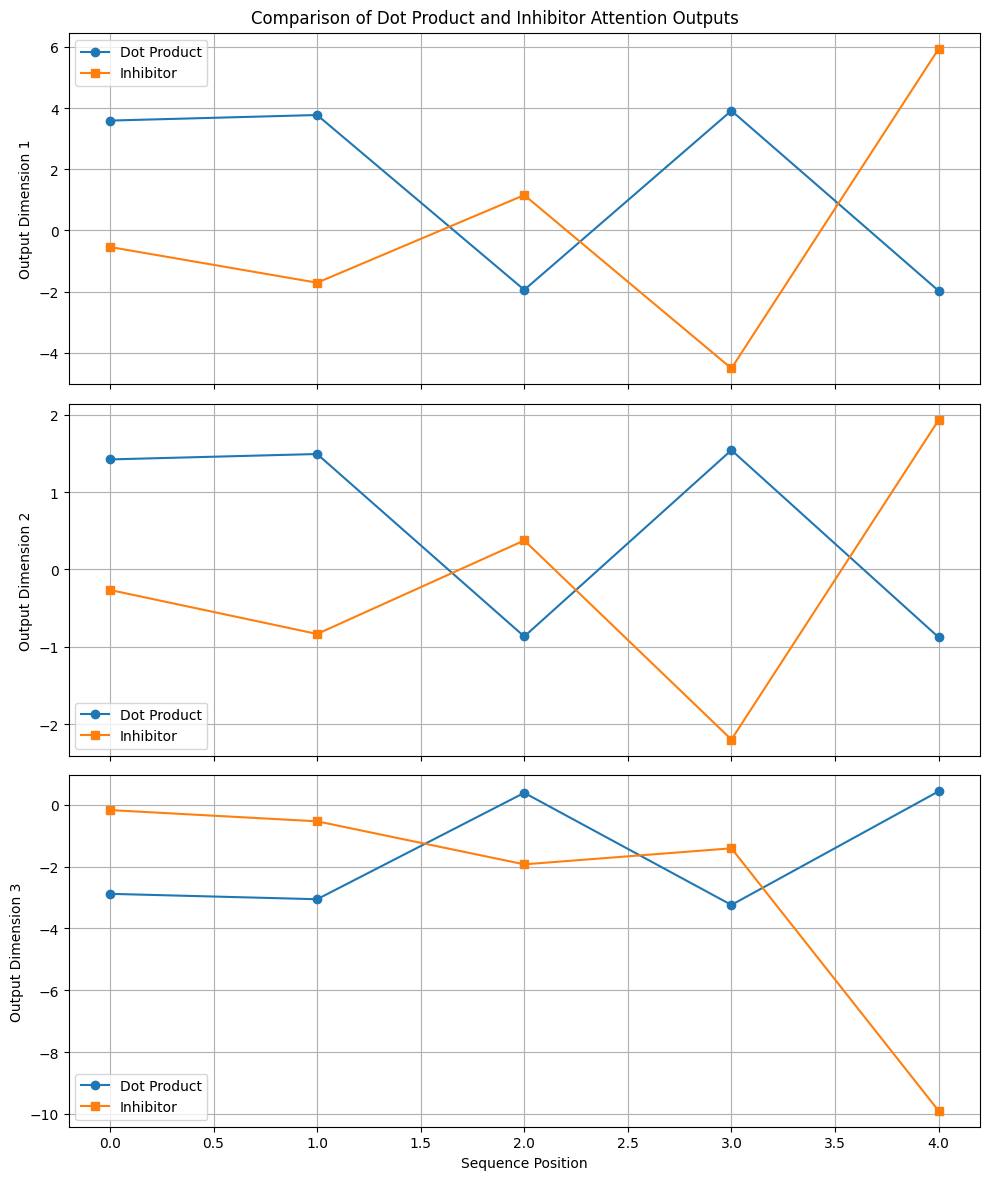

Cosine Similarity: [-0.60861906 -0.60493467 -0.67359451 -0.59622408 -0.6873109 ]
Euclidean Distance: [ 5.22476574  6.47022545  4.06327961  9.40331492 13.3136868 ]
Mean Squared Error: [ 9.09939234 13.95460579  5.50341374 29.47411048 59.08475206]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

class SimpleTransformer:
    def __init__(self, input_dim, hidden_dim, output_dim, attention_type='dot_product'):
        self.Wq = np.random.randn(input_dim, hidden_dim)
        self.Wk = np.random.randn(input_dim, hidden_dim)
        self.Wv = np.random.randn(input_dim, hidden_dim)
        self.Wo = np.random.randn(hidden_dim, output_dim)
        self.attention_type = attention_type

    def dot_product_attention(self, Q, K, V):
        attention_scores = np.dot(Q, K.T) / np.sqrt(K.shape[1])
        attention_probs = softmax(attention_scores)
        return np.dot(attention_probs, V)

    def inhibitor_attention(self, Q, K, V):
        Z = np.abs(Q[:, np.newaxis] - K)/K.shape[1]
        return np.maximum(V[:, np.newaxis] - Z, 0).sum(axis=1)

    def forward(self, X):
        Q = np.dot(X, self.Wq)
        K = np.dot(X, self.Wk)
        V = np.dot(X, self.Wv)

        if self.attention_type == 'dot_product':
            attention_output = self.dot_product_attention(Q, K, V)
        else:
            attention_output = self.inhibitor_attention(Q, K, V)

        return np.dot(attention_output, self.Wo)

# Set random seed for reproducibility
np.random.seed(42)

# Model parameters
input_dim = 4
hidden_dim = 2
output_dim = 3
seq_length = 5

# Create input data
X = np.random.randn(seq_length, input_dim)

# Initialize models
dot_product_model = SimpleTransformer(input_dim, hidden_dim, output_dim, 'dot_product')
inhibitor_model = SimpleTransformer(input_dim, hidden_dim, output_dim, 'inhibitor')

# Use the same weights for both models to ensure fair comparison
inhibitor_model.Wq = dot_product_model.Wq
inhibitor_model.Wk = dot_product_model.Wk
inhibitor_model.Wv = dot_product_model.Wv
inhibitor_model.Wo = dot_product_model.Wo

# Forward pass
dot_product_output = dot_product_model.forward(X)
inhibitor_output = inhibitor_model.forward(X)

# Visualization
fig, axs = plt.subplots(output_dim, 1, figsize=(10, 4*output_dim), sharex=True)
fig.suptitle('Comparison of Dot Product and Inhibitor Attention Outputs')

for i in range(output_dim):
    axs[i].plot(dot_product_output[:, i], label='Dot Product', marker='o')
    axs[i].plot(inhibitor_output[:, i], label='Inhibitor', marker='s')
    axs[i].set_ylabel(f'Output Dimension {i+1}')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Sequence Position')
plt.tight_layout()
plt.show()

# Calculate and print similarity metrics
cosine_similarity = np.sum(dot_product_output * inhibitor_output, axis=1) / (np.linalg.norm(dot_product_output, axis=1) * np.linalg.norm(inhibitor_output, axis=1))
euclidean_distance = np.linalg.norm(dot_product_output - inhibitor_output, axis=1)
mse = np.mean((dot_product_output - inhibitor_output)**2, axis=1)

print("Cosine Similarity:", cosine_similarity)
print("Euclidean Distance:", euclidean_distance)
print("Mean Squared Error:", mse)